# Intel PresentMon Log Analysis

This notebook analyzes performance logs recorded with **Intel PresentMon**.  
The goal is to evaluate PC performance by inspecting CPU, GPU, and FPS metrics over time.

---

## 1. Load the Data

We start by importing the required libraries and loading the PresentMon log file into a pandas DataFrame.

For this example, the log was recorded while running the **Unigine Superposition benchmark**,  
which provides a consistent workload to evaluate CPU, GPU, and FPS behavior.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

file_path = "Logs/pmcap-superposition.exe-250719-220716.csv"
DataFrame = pd.read_csv(file_path)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
DataFrame.head()

,Application,ProcessID,SwapChainAddress,PresentRuntime,SyncInterval,PresentFlags,AllowsTearing,PresentMode,FrameType,TimeInSeconds,MsBetweenSimulationStart,MsBetweenPresents,MsBetweenDisplayChange,MsInPresentAPI,MsRenderPresentLatency,MsUntilDisplayed,MsPCLatency,CPUStartTime,MsBetweenAppStart,MsCPUBusy,MsCPUWait,MsGPULatency,MsGPUTime,MsGPUBusy,MsGPUWait,MsAnimationError,AnimationTime,MsAllInputToPhotonLatency,MsClickToPhotonLatency,InstrumentedLatency,GPUPower,GPUVoltage,GPUFrequency,GPUTemperature,GPUUtilization,3D/ComputeUtilization,MediaUtilization,GPUMemoryPower,GPUMemoryVoltage,GPUMemoryFrequency,GPUMemoryEffectiveFrequency,GPUMemoryTemperature,GPUMemorySize,GPUMemorySizeUsed,GPUMemoryMaxBandwidth,GPUMemoryReadBandwidth,GPUMemoryWriteBandwidth,GPUFanSpeed[0],GPUFanSpeed[1],GPUFanSpeed[2],GPUFanSpeed[3],GPUPowerLimited,GPUTemperatureLimited,GPUCurrentLimited,GPUVoltageLimited,GPUUtilizationLimited,GPUMemoryPowerLimited,GPUMemoryTemperatureLimited,GPUMemoryCurrentLimited,GPUMemoryVoltageLimited,GPUMemoryUtilizationLimited,CPUUtilization,CPUPower,CPUTemperature,CPUFrequency
0,superposition.exe,1148,0x1843739CC00,DXGI,0,0,1,Hardware: Independent Flip,Application,0.00000,NaN,11.4055,12.0522,5.2586,17.3595,17.3595,NaN,0.00000,11.4133,6.1547,5.2586,11.4620,12.0522,12.0522,0.0,-0.0788,16920.3113,NaN,NaN,NaN,60.181,NaN,1515.0,59.0,90.0,NaN,15.0,NaN,NaN,6120.984,NaN,NaN,6442450944,1631023104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5944,NaN,NaN,3444.8775
1,superposition.exe,1148,0x1843739CC00,DXGI,0,0,1,Hardware: Independent Flip,Application,0.01114,NaN,11.1414,11.9330,6.1482,18.1511,18.1511,NaN,0.01141,12.0310,5.8828,6.1482,12.1009,11.9330,11.9330,0.0,-0.5197,16931.7246,NaN,NaN,NaN,60.181,NaN,1515.0,59.0,90.0,NaN,15.0,NaN,NaN,6120.984,NaN,NaN,6442450944,1631023104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5944,NaN,NaN,3444.8775
2,superposition.exe,1148,0x1843739CC00,DXGI,0,0,1,Hardware: Independent Flip,Application,0.02356,NaN,12.4193,11.9110,5.6677,17.6428,17.6428,NaN,0.02344,11.9388,6.2711,5.6677,12.0029,11.9110,11.9110,0.0,0.1200,16943.7556,NaN,NaN,NaN,60.181,NaN,1515.0,59.0,90.0,NaN,15.0,NaN,NaN,6120.984,NaN,NaN,6442450944,1631023104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5944,NaN,NaN,3444.8775
3,superposition.exe,1148,0x1843739CC00,DXGI,0,0,1,Hardware: Independent Flip,Application,0.03749,NaN,13.9330,11.6995,3.6482,15.4093,15.4093,NaN,0.03538,11.9135,8.2653,3.6482,11.9751,11.6995,11.6995,0.0,0.2393,16955.6944,NaN,NaN,NaN,60.181,NaN,1515.0,59.0,90.0,NaN,15.0,NaN,NaN,6120.984,NaN,NaN,6442450944,1631023104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5944,NaN,NaN,3444.8775
4,superposition.exe,1148,0x1843739CC00,DXGI,0,0,1,Hardware: Independent Flip,Application,0.04843,NaN,10.9378,12.3687,4.3997,16.8402,16.8402,NaN,0.04730,11.6893,7.2896,4.3997,11.7611,12.3687,12.3687,0.0,-0.4552,16967.6079,44.5576,NaN,NaN,60.181,NaN,1515.0,59.0,90.0,NaN,15.0,NaN,NaN,6120.984,NaN,NaN,6442450944,1631023104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5944,NaN,NaN,3444.8775


## 2. Build the Analysis DataFrame

We assemble a new `DataFrame` with just the columns we’ll analyze:
- `TimeInSeconds`: wall-clock time since capture start (seconds).
- `CPUFrequency`, `GPUFrequency`: reported operating frequencies.
- `MsCPUBusy`, `MsGPUBusy`: CPU/GPU busy time per frame (milliseconds).
- `CPUUtilization`, `GPUUtilization`: utilization as a percentage.
This keeps downstream computations focused and consistent.

In [ ]:
# --- Create DataFrame with the wanted measures ---
df = pd.DataFrame({
    'TimeInSeconds': DataFrame["TimeInSeconds"],
    'CPUFrequency': DataFrame["CPUFrequency"],
    'GPUFrequency': DataFrame["GPUFrequency"],
    'MsCPUBusy': DataFrame["MsCPUBusy"],
    'MsGPUBusy': DataFrame["MsGPUBusy"],
    'CPUUtilization': DataFrame["CPUUtilization"],
    'GPUUtilization': DataFrame["GPUUtilization"],
})

## 3. Transform Frametime into FPS and Smooth Signals

#### 3.1 Convert Frametime to FPS
PresentMon provides per-frame latency in **milliseconds** as `MsBetweenPresents` (time between frame presents).  
We convert frametime to instantaneous FPS via:
$$
\text{FPS} = \frac{1000}{\text{MsBetweenPresents}}
$$

#### 3.2 Set Timedelta Index
We set the index to `TimedeltaIndex` derived from `TimeInSeconds`.  
This enables **time-based rolling windows** (e.g., `"500ms"`) instead of row-based windows, which is important because it smooths short-term spikes and shows the underlying performance trend, making patterns like stutter or bottlenecks easier to spot.

#### 3.3 Apply Rolling Windows for Smoothing
We compute smoothed series with **time windows**:

- **FPS (avg)** over a `500ms` window  
- **FPS (1% low)** over a `500ms` window using a rolling quantile at `0.01`  
- **CPU/GPU Busy (avg)** over a `100ms` window  

These rolling calculations reduce noise and make it easier to identify stutters or bottlenecks over time.

In [14]:
# --- Convert frametime to FPS ---
frame_time_col = "MsBetweenPresents"
if frame_time_col not in DataFrame.columns:
    raise KeyError(f"Expected column '{frame_time_col}' not found.")
df["FPS"] = 1000 / DataFrame[frame_time_col]

# --- Use TimedeltaIndex for time-based rolling windows ---
df = df.set_index(pd.to_timedelta(DataFrame["TimeInSeconds"], unit="s"))

# --- Compute FPS statistics with a rolling window (500 ms) ---
# 500 ms is long enough to smooth noise but short enough to capture quick changes
df["FPS_avg"] = df["FPS"].rolling("500ms").mean()
df["FPS_1pct_low"] = df["FPS"].rolling("500ms").quantile(0.01)

# --- Compute CPU/GPU busy averages with a shorter window (100 ms) ---
# 100 ms keeps utilization curves responsive without per-frame jitter
df["MsCPUBusy_avg"] = df["MsCPUBusy"].rolling("100ms").mean()
df["MsGPUBusy_avg"] = df["MsGPUBusy"].rolling("100ms").mean()

df.head()


,TimeInSeconds,CPUFrequency,GPUFrequency,MsCPUBusy,MsGPUBusy,CPUUtilization,GPUUtilization,FPS,FPS_avg,FPS_1pct_low,MsCPUBusy_avg,MsGPUBusy_avg
TimeInSeconds,,,,,,,,,,,,
0 days 00:00:00,0.00000,3444.8775,1515.0,6.1547,12.0522,16.5944,90.0,87.676998,87.676998,87.676998,6.154700,12.052200
0 days 00:00:00.011140,0.01114,3444.8775,1515.0,5.8828,11.9330,16.5944,90.0,89.755327,88.716162,87.697781,6.018750,11.992600
0 days 00:00:00.023560,0.02356,3444.8775,1515.0,6.2711,11.9110,16.5944,90.0,80.519836,85.984054,80.662979,6.102867,11.965400
0 days 00:00:00.037490,0.03749,3444.8775,1515.0,8.2653,11.6995,16.5944,90.0,71.772052,82.431053,72.034485,6.643475,11.898925
0 days 00:00:00.048430,0.04843,3444.8775,1515.0,7.2896,12.3687,16.5944,90.0,91.426064,84.230055,72.121963,6.772700,11.992880


#### 3.4 Select the test duration

To avoid startup and shutdown anomalies, we remove the first and last 20 seconds of the log.  
This ensures that the analysis focuses on steady-state performance.

In [ ]:
Time_offset = 20
df = df[(df["TimeInSeconds"] > Time_offset)                                     # to remove the first 20 seconds
    # & (df["TimeInSeconds"] < (df["TimeInSeconds"].max() - Time_offset))   # to remove the last 20 seconds
]
df.head()

,TimeInSeconds,CPUFrequency,GPUFrequency,MsCPUBusy,MsGPUBusy,CPUUtilization,GPUUtilization,FPS,FPS_avg,FPS_1pct_low,MsCPUBusy_avg,MsGPUBusy_avg
TimeInSeconds,,,,,,,,,,,,
0 days 00:00:20.010000,20.01,3226.9451,1470.0,6.6514,14.0053,13.4594,98.0,70.638929,72.549488,63.484343,6.850825,13.765688
0 days 00:00:20.030000,20.03,3226.9451,1470.0,6.2311,13.9517,13.4594,98.0,83.162849,72.653148,63.414862,6.891371,13.765471
0 days 00:00:20.040000,20.04,3226.9451,1470.0,7.1703,13.9772,13.4594,98.0,66.869504,72.552370,63.043307,6.929814,13.856971
0 days 00:00:20.060000,20.06,3226.9451,1470.0,8.0841,13.9945,13.4594,98.0,67.299280,72.410676,63.043307,7.139586,13.836714
0 days 00:00:20.070000,20.07,3226.9451,1470.0,7.1890,13.2593,13.4594,98.0,76.551508,72.572166,63.043307,7.026243,13.749029


## 4. FPS Analysis

We visualize:
- **Average FPS** over time
- **1% Low FPS** to capture stutter or frame drops

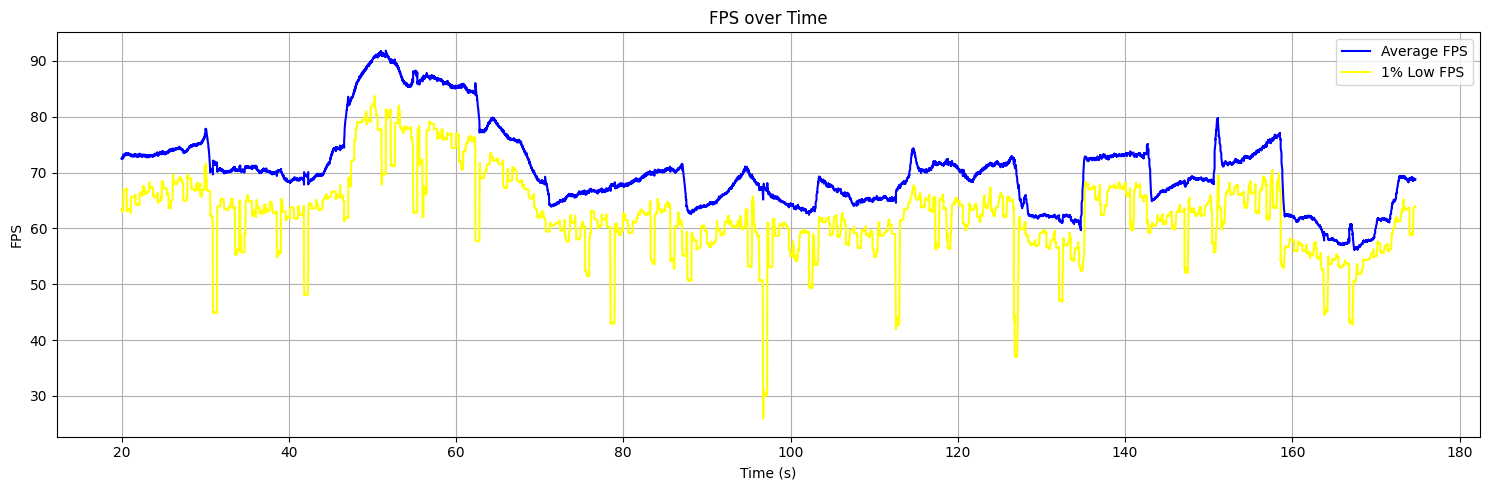

In [16]:
# Plot avg FPS and 1% Low FPS over time
plt.figure(figsize=(15, 5))
plt.plot(df["TimeInSeconds"], df["FPS_avg"], color="blue", label="Average FPS")
plt.plot(df["TimeInSeconds"], df["FPS_1pct_low"], color="yellow", label="1% Low FPS")

plt.xlabel("Time (s)")
plt.ylabel("FPS")
plt.title("FPS over Time")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# # Plot raw FPS
# plt.figure(figsize=(15, 5))
# plt.plot(df["TimeInSeconds"], df["FPS"], color="blue", label="raw FPS")
# plt.xlabel("Time (s)")
# plt.ylabel("FPS")
# plt.title("FPS over Time")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

## 5. CPU vs GPU Utilization

We plot CPU and GPU busy percentages over time.  
This helps identify:
- Whether the workload is CPU-bound or GPU-bound
- Potential bottlenecks


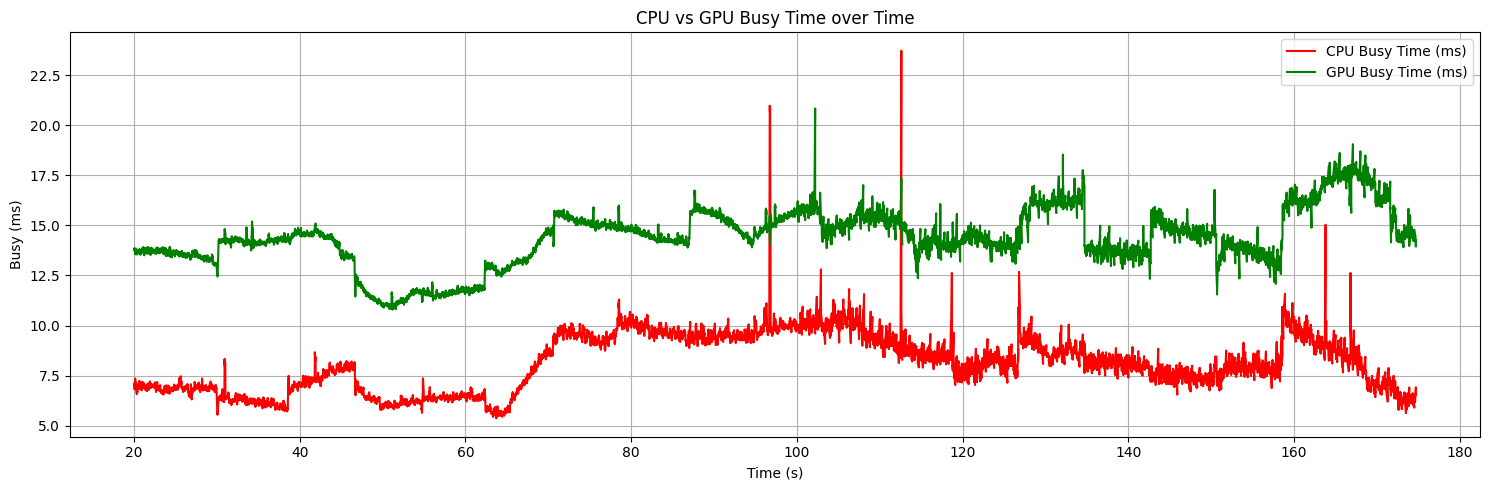

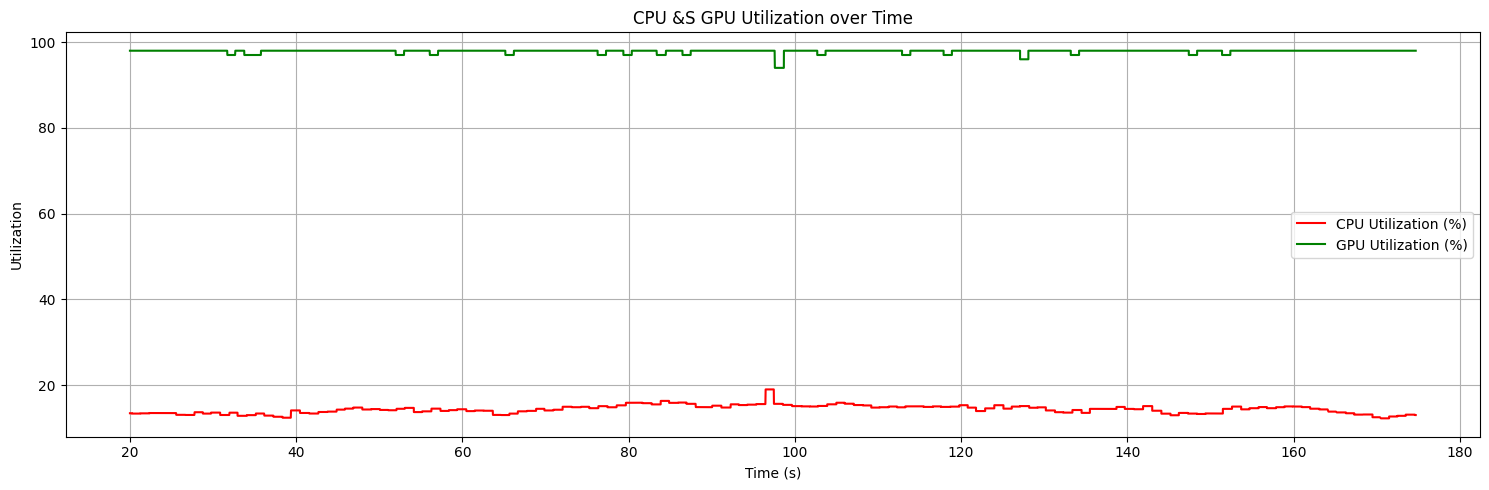

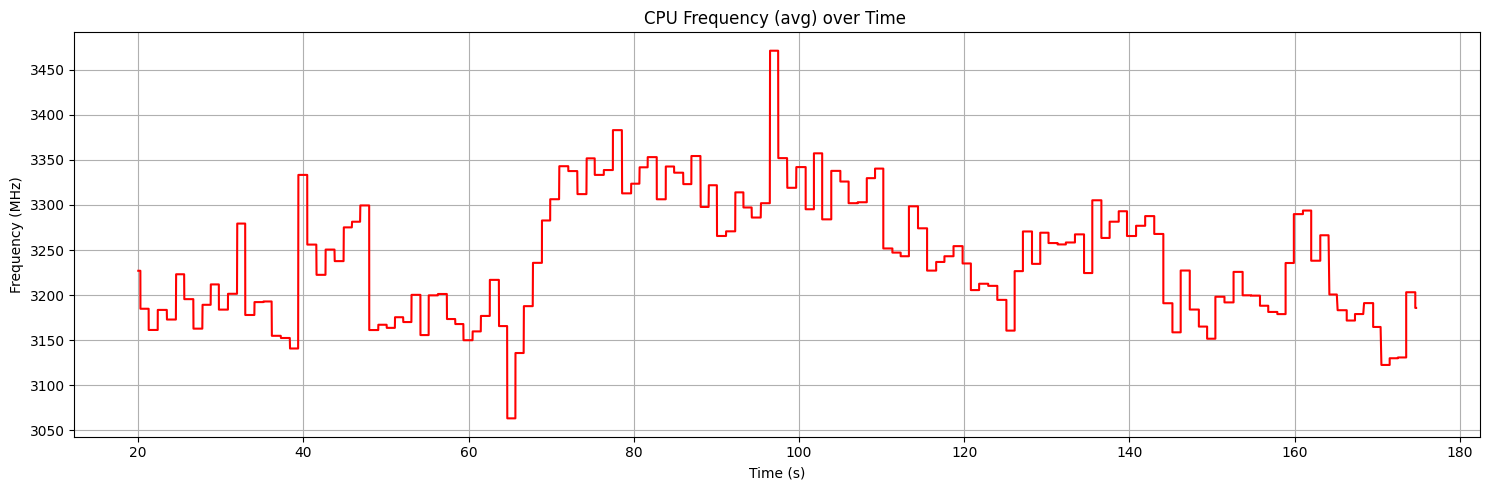

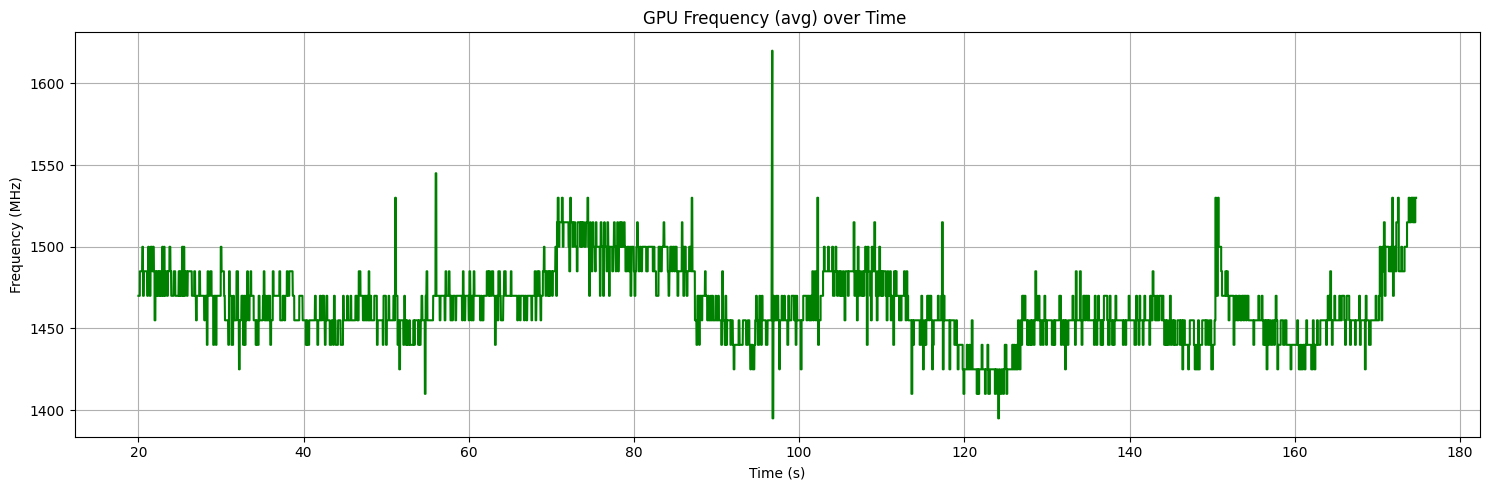

In [17]:
# Plot CPU vs GPU Busy (avg) over Time 
plt.figure(figsize=(15, 5))
plt.plot(df["TimeInSeconds"], df["MsCPUBusy_avg"], color="red", label="CPU Busy Time (ms)")
plt.plot(df["TimeInSeconds"], df["MsGPUBusy_avg"], color="green", label="GPU Busy Time (ms)")

plt.xlabel("Time (s)")
plt.ylabel("Busy (ms)")
plt.title("CPU vs GPU Busy Time over Time")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# # Plot CPU vs GPU Busy (raw) over Time 
# plt.figure(figsize=(15, 5))
# plt.plot(df["TimeInSeconds"], df["MsCPUBusy"], color="red", label="CPU Busy Time")
# plt.plot(df["TimeInSeconds"], df["MsGPUBusy"], color="green", label="GPU Busy Time")

# plt.xlabel("Time (s)")
# plt.ylabel("Busy (ms)")
# plt.title("CPU vs GPU Busy Time over Time")
# plt.legend()
# plt.tight_layout()
# plt.show()


# Plot CPU &S GPU Utilization over Time
plt.figure(figsize=(15, 5))
plt.plot(df["TimeInSeconds"], df["CPUUtilization"], color="red", label="CPU Utilization (%)")
plt.plot(df["TimeInSeconds"], df["GPUUtilization"], color="green", label="GPU Utilization (%)")

plt.xlabel("Time (s)")
plt.ylabel("Utilization")
plt.title("CPU &S GPU Utilization over Time")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Plot CPU & GPU Frequency over Time 
plt.figure(figsize=(15, 5))
plt.plot(df["TimeInSeconds"], df["CPUFrequency"], color="red")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (MHz)")
plt.title("CPU Frequency (avg) over Time ")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(df["TimeInSeconds"], df["GPUFrequency"], color="green")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (MHz)")
plt.title("GPU Frequency (avg) over Time ")
plt.grid()
plt.tight_layout()
plt.show()

## 6. Performance Summary

We calculate key statistics:
- **Average FPS**
- **1% Low FPS**

These numbers provide a quick benchmark-style summary of system performance during the whole test.

In [18]:
# Average FPS
avg_fps = df["FPS"].mean()

# 1% low FPS
worst_1pct_count = max(int(len(df) * 0.01), 1)
fps_1pct_low = df["FPS"].sort_values().iloc[:worst_1pct_count].mean()

# 90th percentile frequency
gpu_freq_90th = df["GPUFrequency"].quantile(0.90)
cpu_freq_90th = df["CPUFrequency"].quantile(0.90)

print(f"Average FPS:     {avg_fps:.2f}")
print(f"1% Low FPS:      {fps_1pct_low:.2f}")
print(f"GPU 90% freq:    {gpu_freq_90th:.0f} MHz")
print(f"CPU 90% freq:    {cpu_freq_90th:.0f} MHz")

Average FPS:     71.15
1% Low FPS:      52.03
GPU 90% freq:    1500 MHz
CPU 90% freq:    3336 MHz
